# Polychromatic Propagation

This how-to is extremely brief, and covers how to use prysm to model polychromatic propagation.  The user should already be familiar with the [First Diffraction Model](./First-Diffraction-Model.ipynb) tutorial before working through this how-to.

In optics education, most problems are monochromatic.  In real hardawre, there are some special cases of highly monochromatic sources, such as the HeNe and other noble gas lasers.  However, stars and most other light sources have significant spectral bandwidth.  Properly modeling those situations requires the propagation of polychromatic fields.  Recall that the relationship between the sampling in a pupil plane and the far field is:

$$
\theta = \frac{\lambda}{D}
$$

where $D$ is the diameter of the aperture.  Additionally, if we use a lens to focus the beam and invoke the Fourier transforming property of lenses, then:

$$
x = \frac{f\lambda}{D} = \lambda\text{F#}
$$

where $x$ is the abscissa of the image plane and $f$ is the focal length of the lens.

This is chromatic (depends on $\lambda$), so we cannot just compute the Fourier transform of the pupil function for multiple wavelengths and sum them; they will exist on different grids.  The solution to this problem offered by prysm is the matrix triple product DFT, an alternative to the FFT which allows the output grid to be specified directly, rather than being prescribed by the FFT operation (and perhaps any padding attached to the FFT operation).  prysm contains an extremely fast implementation of the matrix triple product DFT, and exposes an interface to it that embeds these changes of variables.

Because everything uses physical units, we'll choosen to model a 50mm F/4 lens with a large amount of defocus, so that we can see the blurring of the fresnel rings by broadband illumination.  We'll start by setting up our pupil, and showing a PSF propagated by the usual FFT method:

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

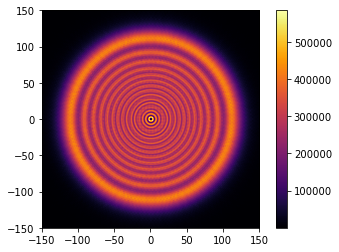

In [11]:
import numpy as np

from scipy import stats

from prysm import (
    coordinates,
    geometry,
    propagation,
    polynomials,
    _richdata
)

res = 512
fno = 4
efl = 150
epd = efl/fno
r_aper = epd / 2
wvl0 = .550

res_el = wvl0 * fno * 1.22 / 4 # 4 pixels per airy radius

xi, eta = coordinates.make_xy_grid(256, diameter=epd)
r, t = coordinates.cart_to_polar(xi,eta)
dx = xi[0,1] - xi[0,0]

r_aber = r / r_aper

coef = wvl0 * 1e3 * 15 # 10 waves of defocus
phs = polynomials.hopkins(0,2,0,r_aber,t,1) * coef

amp = geometry.circle(r_aper, r)

wf = propagation.Wavefront.from_amp_and_phase(amp, phs, wvl0, dx)
focused = wf.focus(efl, Q=4).intensity
focused.plot2d(xlim=150)

Having seen the monochromatic model, we'll now view a polychromatic version of the same.  For the sake of simplicity, we'll assume uniform spectral weighting.  The function `sum_of_xy_modes` is used from the polynomials module to avoid including a duplicate of the same in the psf module.  It is an optimized routine for performing a weighted sum of 2D arrays.

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

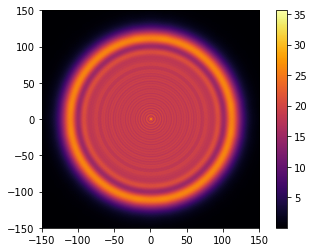

In [15]:
halfbw = 0.2
wvls = np.linspace(wvl0*(1-halfbw), wvl0*(1+halfbw), 11)  # 11 discrete wavelengths
spectral_weights = np.ones_like(wvls)

components = []
for wvl in wvls:
    wf = propagation.Wavefront.from_amp_and_phase(amp, phs, wvl, dx)
    focused = wf.focus_fixed_sampling(efl, res_el, 512) # 512 samples in the output domain
    components.append(focused.intensity.data) # sum of intensities, wvls are incoherent to each other
    
# psf is just an array
psf = polynomials.sum_of_2d_modes(components, spectral_weights)
# until we enrich it
psf = _richdata.RichData(psf, res_el, wvl0)
psf.plot2d(xlim=150)

We can see that the propagation of a broadband polychromatic field exhibits a lower modulation of the Fresnel rings than the propagation of the monochromatic field.  The Fresnel rings are an interference effect, and due to the lower coherence of a broadband field they are less visible.

One can see that the broadband PSF has much lower peak intensity -- this is different to the different normalization rules used by the FFT and MDFT propagation routines in prysm.  This property is subject to change.